In [67]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from utils import *

In [12]:
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
%load_ext autoreload
%autoreload 2

### Reading data

In [23]:
path = 'data/'
data = pd.read_excel(path + 'Oncothromb_bbddMarzo2018.xlsx')

In [19]:
asdf = data[data['excluido']==0]
asdf.shape

(391, 92)

In [21]:
print(asdf['caseAtVisit'].isna().sum())
asdf['caseAtVisit'].value_counts()

302


1.0    43
0.0    30
2.0    12
3.0     4
Name: caseAtVisit, dtype: int64

In [8]:
data['diabetesM'].value_counts()

No    255
-      77
Sí     76
Name: diabetesM, dtype: int64

In [36]:
# proprocess_data() returns:
# 1) genetic variables, preprocessed as in the paper
# 2) clinical variables, preprocessed as in the paper
# 3) clinical-genetic variables used to compute the final TiC-Onco score in the paper
# 4) labels (No-VTE=0, VTE=1)

# the parameter summary allows to compare the obtained data with the population characteristics table in the paper (Table 1)

gen_data, clinical_data, X, y = preprocess_data(data, drop_na=True, summary=True)

Initial shape: (391, 26)
Genetic data shape: (391, 11)
Clinical data shape: (391, 20)
Clinical-Genetic data shape: (391, 8)
Target shape: (391,)

Number of No-VTE (0) and VTE (1): [318  73]

               Variable  VTE (n)  VTE (%)  No-VTE (n)  No-VTE (%)
0                  sexe       28     38.4         107        33.6
1                edatDx       64   1130.4          64      1038.8
2             diabetesM       12     16.4          62        19.5
3               fumador       21     28.8          66        20.8
4                Family        6      8.2          12         3.8
5                   bmi       37     50.7         145        45.6
6                dislip       29     39.7         106        33.3
7              hta_desc       33     45.2         141        44.3
8               khorana       17     23.3          57        17.9
9           hemoglobina        5      6.8          17         5.3
10            plaquetes       14     19.2          73        23.0
11            leu

### Target variable

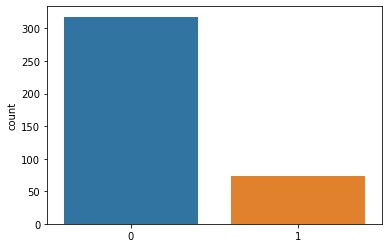

In [37]:
sns.countplot(y)
plt.show()

In [38]:
sum(elem==0 for elem in y), sum(elem==1 for elem in y)
# IT SHOULD BE (320, 71) !

(318, 73)

### 1) Genetic variables
Here I consider the genetic variables indicated in the paper (1. Development of a genetic risk score)

TODO: A1 blood group

In [39]:
gen_data.tail()

,rs6025,rs4524,rs1799963,rs1801020,rs5985,rs121909548,rs2232698,rs8176719,rs7853989,rs8176749,rs8176750
386,0,1,1,0,0,0,1,2,0,0,1
387,0,1,0,0,0,0,0,1,0,0,1
388,0,1,0,0,0,0,0,2,1,1,0
389,0,2,0,0,2,0,0,1,0,0,0
390,0,2,0,1,1,0,0,0,0,0,0


In [40]:
# we can compare the number of patients in each group to see that it coincides with the results in Table 1
print(len(gen_data[gen_data['rs6025']==1])) # 9
print(len(gen_data[gen_data['rs5985']==2])) # 22

9
22


In [43]:
# fitting a logistic model
gen_model = sm.Logit(y, sm.add_constant(gen_data)).fit(maxiter=100, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.466806
         Iterations: 97
         Function evaluations: 99
         Gradient evaluations: 99


In [44]:
gen_model.summary() # P>|z| differ from the paper results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  391
Model:                          Logit   Df Residuals:                      379
Method:                           MLE   Df Model:                           11
Date:                Thu, 13 May 2021   Pseudo R-squ.:                 0.03032
Time:                        19:05:47   Log-Likelihood:                -182.52
converged:                       True   LL-Null:                       -188.23
Covariance Type:            nonrobust   LLR p-value:                    0.4091
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.3738      0.475     -4.995      0.000      -3.305      -1.442
rs6025          0.7709      0.730      1.056      0.291      -0.660       2.202
rs4524          0.4848      0.245      1.980      0.048       0.005       0.965
rs1799963      -0.3556      0.762     -0.467      0.641      -1.849       1.138
rs1801020      -0.1025      0.242     -0.423      0.672      -0.578       0.373
rs5985          0.2266      0.216      1.049      0.294      -0.197       0.650
rs121909548    -8.5043    136.131     -0.062      0.950    -275.317     258.308
rs2232698       1.5113      0.708      2.136      0.033       0.124       2.898
rs8176719       0.0813      0.214      0.380      0.704      -0.338       0.501
rs7853989      -0.2231      1.012     -0.220      0.826      -2.207       1.761
rs8176749      -0.1131      1.061     -0.107      0.915      -2.192       1.966
rs8176750      -0.0825      0.416     -0.198      0.843      -0.898       0.733
===============================================================================
"""

**Computing p-values using permutation test**

In [48]:
lr = LogisticRegression(penalty='none')
gen_pvalues = perm_test(gen_data, y, lr)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [49]:
# close to the previous ones
gen_pvalues 

[0.364, 0.046, 0.628, 0.686, 0.304, 0.58, 0.178, 0.692, 0.768, 0.938, 0.858]

### 2) Clinical variables
Now I select the clinical variables considered in the paper (2. Selection of clinical variables)

In [51]:
clinical_data.tail()

,sexe,edatDx,diabetesM,fumador,Family,bmi,dislip,hta_desc,khorana,hemoglobina,plaquetes,leucocits,tipusTumor_colon,tipusTumor_pancreas,tipusTumor_pulmon,tipusTumor_esofago,tipusTumor_estomago,estadiGrup_I_II,estadiGrup_III,estadiGrup_IV
386,0,67,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
387,0,60,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1
388,0,81,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1
389,0,73,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0
390,0,57,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1


In [52]:
clinical_data.shape

(391, 20)

In [53]:
# we can compare the number of patients in each group to see that it coincides with the results in Table 1
len(clinical_data[clinical_data['sexe']==1]) # 135

135

In [60]:
# fit the model with maximum likelihood function
clinical_model = sm.Logit(y, sm.add_constant(clinical_data)).fit(maxiter=100, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.411626
         Iterations: 77
         Function evaluations: 81
         Gradient evaluations: 81


In [61]:
clinical_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  391
Model:                          Logit   Df Residuals:                      372
Method:                           MLE   Df Model:                           18
Date:                Thu, 13 May 2021   Pseudo R-squ.:                  0.1449
Time:                        19:09:13   Log-Likelihood:                -160.95
converged:                       True   LL-Null:                       -188.23
Covariance Type:            nonrobust   LLR p-value:                 1.497e-05
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9531   2.15e+05   -9.1e-06      1.000   -4.21e+05    4.21e+05
sexe                    0.0332      0.310      0.107      0.915      -0.575       0.641
edatDx                  0.0108      0.015      0.742      0.458      -0.018       0.039
diabetesM              -0.8004      0.424     -1.887      0.059      -1.632       0.031
fumador                 0.3404      0.353      0.963      0.335      -0.352       1.033
Family                  0.9268      0.602      1.539      0.124      -0.254       2.107
bmi                     0.6142      0.310      1.983      0.047       0.007       1.221
dislip                  0.3406      0.317      1.074      0.283      -0.281       0.962
hta_desc               -0.0951      0.311     -0.306      0.760      -0.704       0.514
khorana                 0.0471      0.562      0.084      0.933      -1.054       1.148
hemoglobina             0.9387      0.595      1.579      0.114      -0.227       2.104
plaquetes              -0.2378      0.428     -0.555      0.579      -1.077       0.601
leucocits              -0.0949      0.445     -0.213      0.831      -0.968       0.778
tipusTumor_colon       -0.6531   1.33e+07  -4.91e-08      1.000   -2.61e+07    2.61e+07
tipusTumor_pancreas     1.0420   1.33e+07   7.84e-08      1.000   -2.61e+07    2.61e+07
tipusTumor_pulmon      -1.0010   1.33e+07  -7.53e-08      1.000   -2.61e+07    2.61e+07
tipusTumor_esofago     -0.6434   1.33e+07  -4.84e-08      1.000   -2.61e+07    2.61e+07
tipusTumor_estomago    -0.6976   1.33e+07  -5.25e-08      1.000   -2.61e+07    2.61e+07
estadiGrup_I_II        -1.5736   1.33e+07  -1.18e-07      1.000   -2.61e+07    2.61e+07
estadiGrup_III         -0.5380   1.33e+07  -4.05e-08      1.000   -2.61e+07    2.61e+07
estadiGrup_IV           0.1584   1.33e+07   1.19e-08      1.000   -2.61e+07    2.61e+07
=======================================================================================
"""

In [62]:
clinical_pvalues = perm_test(clinical_data, y, lr)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [63]:
clinical_pvalues 

[0.906,
 0.494,
 0.04,
 0.39,
 0.156,
 0.026,
 0.24,
 0.782,
 0.824,
 0.124,
 0.506,
 0.74,
 0.06,
 0.018,
 0.01,
 0.384,
 0.102,
 0.0,
 0.226,
 0.724]

### 3) Genetical and clinical markers included in the TiC-Onco risk score model
Here I use the variables selected in steps 1 and 2 of the paper (see table 3)

In [64]:
X.head()

,rs2232698,rs6025,rs5985,rs4524,bmi,Family,primary_tumour_site,tumour_stage
0,0,0,1,1,1,0,0,1
1,0,0,0,1,0,0,2,0
2,0,0,0,2,0,0,1,1
3,0,0,0,2,0,0,0,1
4,0,0,0,2,1,0,0,1


In [65]:
X.shape

(391, 8)

### Evaluating TiC-Onco risk score

In [68]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2001)
X_train.shape, X_test.shape

((293, 8), (98, 8))

In [73]:
model = sm.Logit(endog=y_train, exog=X_train).fit(maxiter=100, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.545228
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50


In [74]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  293
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                            7
Date:                Thu, 13 May 2021   Pseudo R-squ.:                -0.07550
Time:                        19:12:57   Log-Likelihood:                -159.75
converged:                       True   LL-Null:                       -148.54
Covariance Type:            nonrobust   LLR p-value:                     1.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
rs2232698               0.1908      0.892      0.214      0.831      -1.558       1.940
rs6025                  0.8559      0.795      1.077      0.281      -0.702       2.413
rs5985                 -0.1491      0.228     -0.654      0.513      -0.596       0.298
rs4524                 -0.7260      0.147     -4.945      0.000      -1.014      -0.438
bmi                    -0.3323      0.264     -1.257      0.209      -0.850       0.186
Family                  0.2571      0.625      0.411      0.681      -0.968       1.483
primary_tumour_site    -0.0413      0.154     -0.269      0.788      -0.342       0.260
tumour_stage            0.4389      0.274      1.603      0.109      -0.098       0.976
=======================================================================================
"""

In [75]:
perm_test(X_train, y_train, lr)

[0.354, 0.328, 0.272, 0.006, 0.082, 0.706, 0.014, 0.0]

In [76]:
# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

AUC score (train): 0.4874
AUC score (test): 0.5452


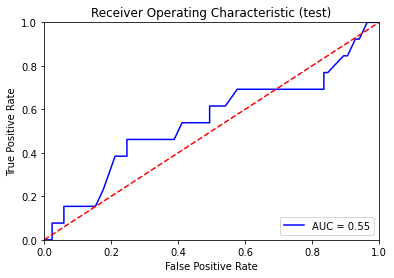


Accuracy in train set (%): 67.58
Accuracy in test set (%): 73.47

=====Train set=====
[[186  47]
 [ 48  12]]

Sensivity (%): 20.0
Specificity (%): 79.83
Precision (%): 20.34
NPV (%): 79.49000000000001

=====Test set=====
[[67 18]
 [ 8  5]]

Sensivity (%): 38.46
Specificity (%): 78.82000000000001
Precision (%): 21.740000000000002
NPV (%): 89.33


In [77]:
evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

### Evaluating Khorana score

In [89]:
# High risk: Khorana >= 3
pred_khorana = clinical_data['khorana']
len(pred_khorana)

391

In [90]:
acc_khorana = sum(pred_khorana == y) / len(y)
print("Accuracy (%):", round(acc_khorana*100, 2))

Accuracy (%): 71.1


In [91]:
tn, fp, fn, tp = confusion_matrix(y, pred_khorana).ravel()
confusion_matrix(y, pred_khorana)

array([[261,  57],
       [ 56,  17]], dtype=int64)

In [92]:
sensivity_khorana = tp / (tp+fn)
specificity_khorana = tn / (fp+tn)
PPV_khorana = tp / (tp+fp)
NPV_khorana = tn / (fn+tn) 

In [93]:
print("Sensivity (%):", round(sensivity_khorana*100,2))
print("Specificity (%):", round(specificity_khorana,4)*100)
print("PPV (%):", round(PPV_khorana,4)*100)
print("NPV (%):", round(NPV_khorana,4)*100)

Sensivity (%): 23.29
Specificity (%): 82.08
PPV (%): 22.97
NPV (%): 82.33
